In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
cdpDir   = workDir+'cdp_data/'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

band   = '1A'
infile_PixelToPixelMap = 'NonLinearityCorrection_OutputParameters_CV3_MRS_RAD_14_Band{}.npy'.format(band)
infile_BestModel = 'NonLinearityCorrection_OutputParameters_BestModel_CV3_MRS_RAD_14_Band{}.npy'.format(band)

In [4]:
nl_coefficients_PixelToPixelMap = np.load(infile_PixelToPixelMap)
nl_coefficients_BestModel = np.load(infile_BestModel)

if band[0] in ['1','2']:
    filename = cdpDir+'MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits'
if band in ['3A','4A']:
    filename = cdpDir+'MIRI_FM_MIRIFULONG_34SHORT_LINEARITY_06.02.00.fits'
elif band in ['3B','4B']:
    filename = cdpDir+'MIRI_FM_RAL_MIRIFULONG_34MEDIUM_LINEARITY_07.02.00.fits'
elif band in ['3C','4C']:
    filename = cdpDir+'MIRI_FM_MIRIFULONG_34LONG_LINEARITY_06.02.00.fits'
nl_coefficients_CDP = fits.open(filename)[1].data

In [5]:
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
sel = (d2cMaps['sliceMap'] > 100*int(band[0])) & (d2cMaps['sliceMap'] < 100*(int(band[0])+1) )

In [6]:
# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [7]:
# CV3 MIRM33541 (MRS_RAD_11, observations of internal calibration source in nominal and cross-dichroic configurations)
filename = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')
# CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
# filename = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')
# Other dataset
# lvl1path_new = '/STER/miriman/FM/'
# filename = mrsobs.MIRI_internal_calibration_source(lvl1path_new,band,campaign='FM',output='filename').replace('_LVL2','')
# filename = mrsobs.FM_MTS_BB_extended_source(lvl1path_new,band,bb_temp='800K',output='filename')[0].replace('_LVL2','')
# filename = mrsobs.MIRI_high_background(lvl1path_new,band,output='filename').replace('_LVL2','')
# filename = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl1path_new,band,etalon='ET1A',output='filename')[0].replace('_LVL2','')
# filename = workDir+'OTIS_data/LVL1/MIRM32313-SS-V03-7249024654_1_495_SE_2017-09-06T02h54m21.fits'

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [8]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 5
Number of groups/frames per integration: 20
Total number of frames: 100
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (100, 1024, 1032)


In [9]:
image_hdu.close()

<IPython.core.display.Javascript object>


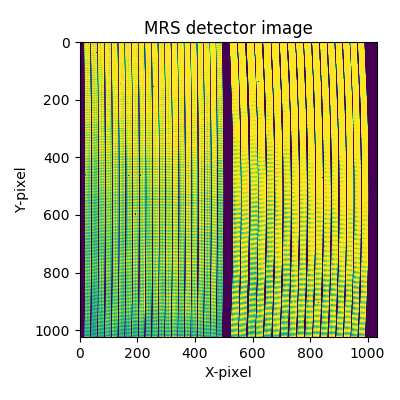

<IPython.core.display.Javascript object>


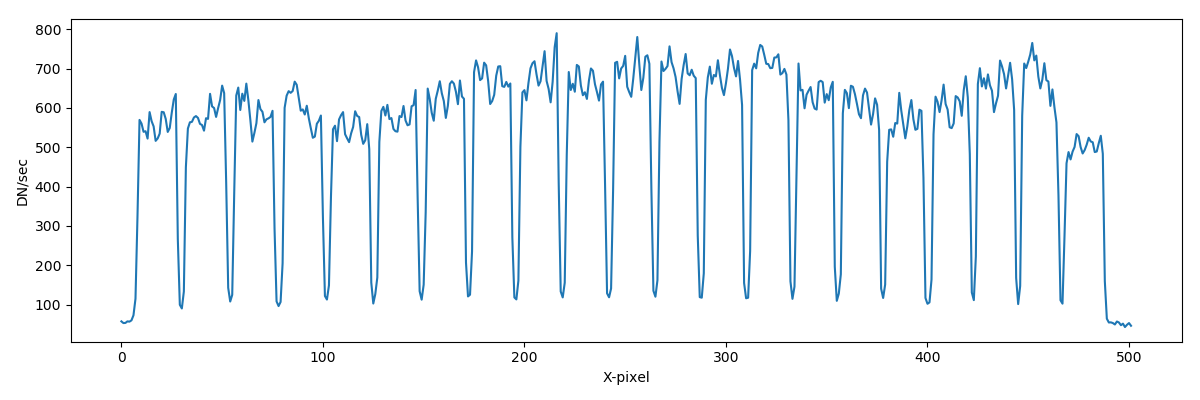

In [10]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=100,vmax=700)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS detector image')
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(slope_img[row,10:512])
elif band[0] in ['2','3']:
    plt.plot(slope_img[row,512:1026])
plt.xlabel('X-pixel')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


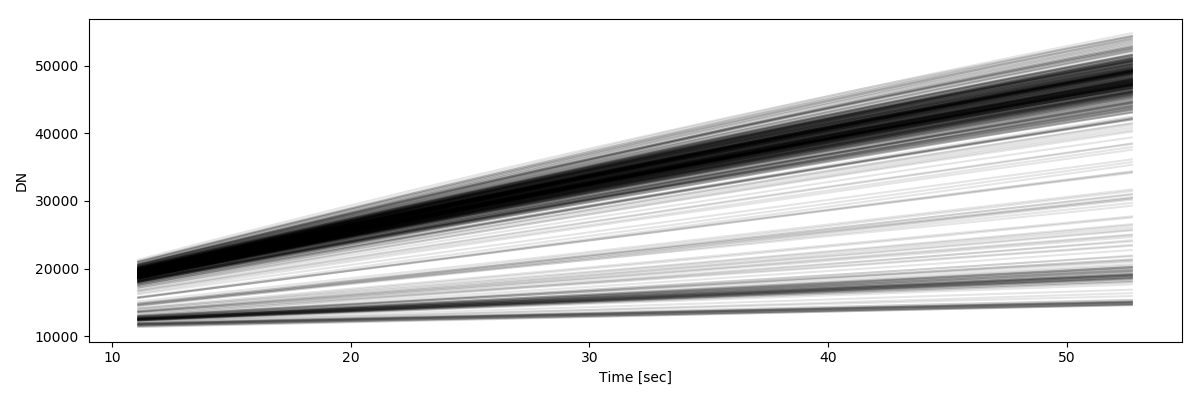

In [13]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

plt.figure(figsize=(12,4))
for ypos in [10]:
    for xpos in range_x:
        time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
        tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
        plt.plot(time3,tramp3,'k',alpha=0.1)
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.tight_layout()

In [14]:
plt.close('all')

## Derive non-linearity correction for a single pixel

<IPython.core.display.Javascript object>


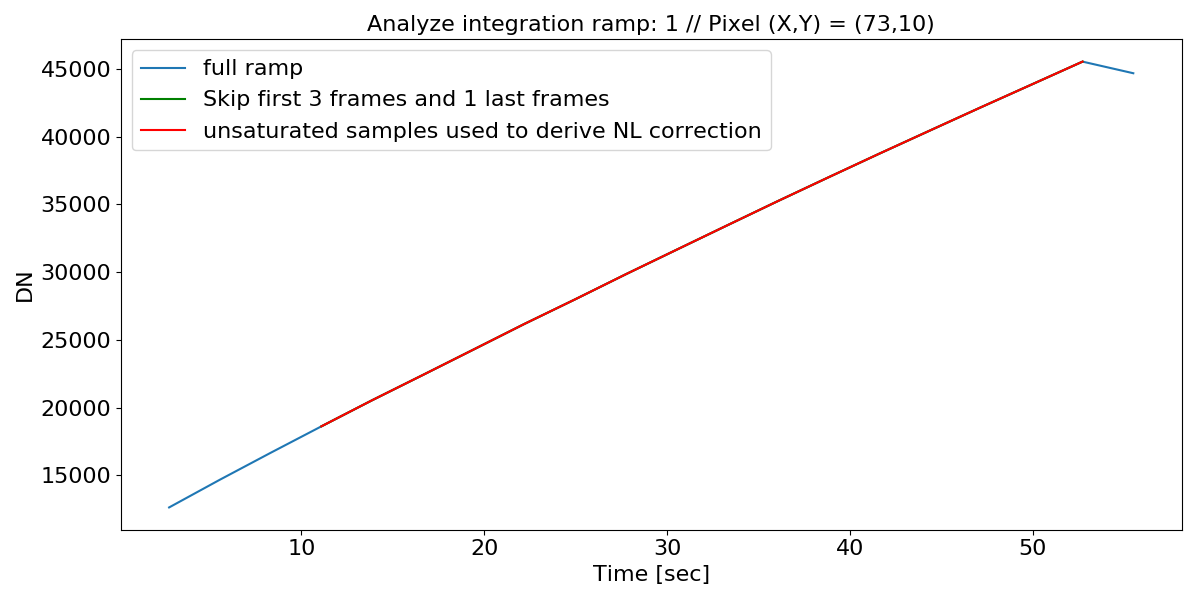

In [15]:
# Define ramp to be used for derivation of non-linearity correction
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

row = 10
ypos,xpos = trace_y[row],trace_x[row]

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

intime,inramp = time3,tramp3

plt.figure(figsize=(12,6))
plt.plot(time,tramp,label='full ramp')
plt.plot(time2,tramp2,'g',label='Skip first {} frames and {} last frames'.format(skip_first,skip_last))
plt.plot(time3,tramp3,'r',label='unsaturated samples used to derive NL correction')
plt.xlabel('Time [sec]',fontsize=16)
plt.ylabel('DN',fontsize=16)
plt.legend(fontsize=16)
plt.title('Analyze integration ramp: {} // Pixel (X,Y) = ({},{})'.format(analyze_ramp,xpos,ypos),fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

In [16]:
# define placeholders
out_ramp = np.zeros_like(inramp, dtype=np.float64)
new_rate = np.zeros(shape=(len(inramp)-1, image_shape[1], image_shape[2]), dtype=np.float64)

print('Output ramp (object shape): {}'.format(out_ramp.shape))
print('New rate (object shape): {}'.format(new_rate.shape))

Output ramp (object shape): (16,)
New rate (object shape): (15, 1024, 1032)


<IPython.core.display.Javascript object>


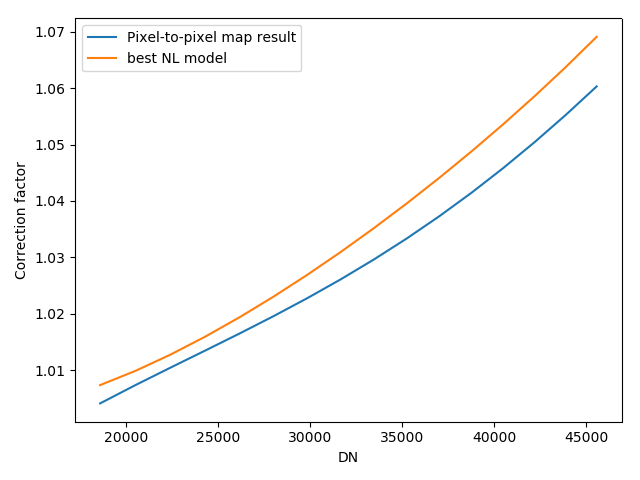

<IPython.core.display.Javascript object>


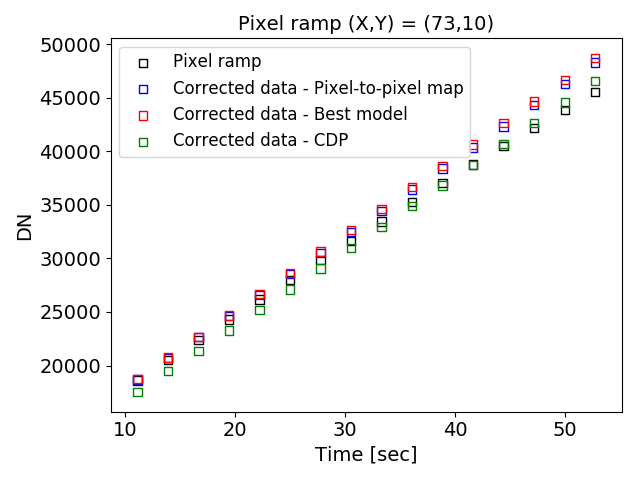

<IPython.core.display.Javascript object>


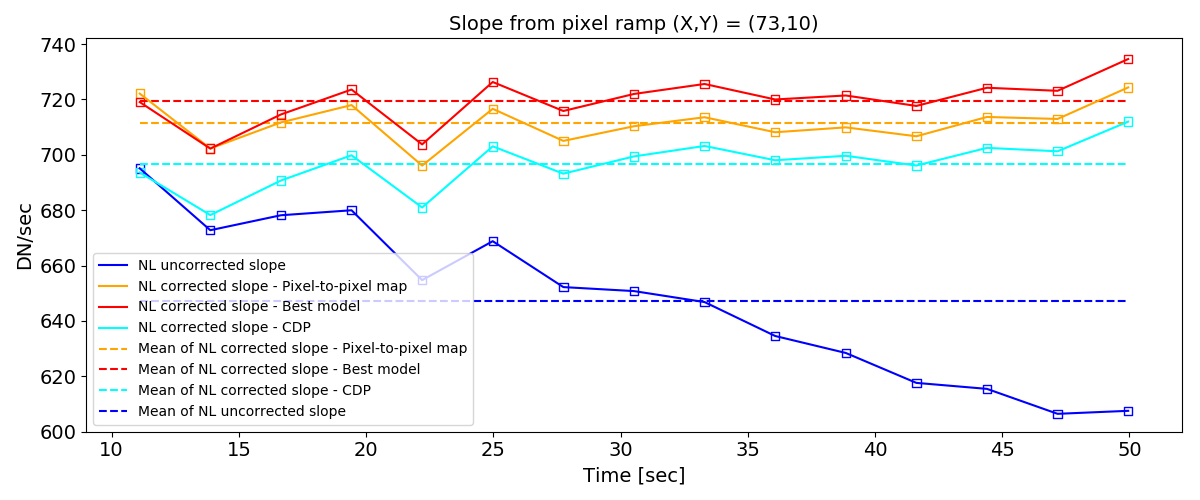

Pixel-dependent mean slope: 711.439364079 DN/sec
NL best model mean slope: 719.605163973 DN/sec
NL CDP mean slope: 696.803028614 DN/sec


In [17]:
cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
cor_factor_BestModel = np.polynomial.polynomial.polyval(inramp, nl_coefficients_BestModel[:, ypos, xpos])

plt.figure()
plt.plot(inramp,cor_factor_PixelToPixelMap,label='Pixel-to-pixel map result')
plt.plot(inramp,cor_factor_BestModel,label='best NL model')
plt.xlabel('DN')
plt.ylabel('Correction factor')
plt.legend()
plt.tight_layout()

# correct ramp by applying derived NL correction
corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
corrected_ramp_BestModel = cor_factor_BestModel * inramp
corrected_ramp_CDP = np.zeros(len(inramp))
for i in range(len(inramp)):
    corrected_ramp_CDP[i] = corrected_ramp_CDP[i]+nl_coefficients_CDP[0,ypos, xpos]+\
                            nl_coefficients_CDP[1,ypos, xpos]*inramp[i]+\
                            nl_coefficients_CDP[2,ypos, xpos]*inramp[i]**2+\
                            nl_coefficients_CDP[3,ypos, xpos]*inramp[i]**3+\
                            nl_coefficients_CDP[4,ypos, xpos]*inramp[i]**4

time_array = np.arange(skip_first+len(inramp)+skip_last+1)*frame_delta_time
plt.figure()
plt.scatter(intime,inramp,marker='s',facecolors='none',edgecolors='k',label='Pixel ramp')
plt.scatter(intime,corrected_ramp_PixelToPixelMap,marker='s',facecolors='none',edgecolors='b',label='Corrected data - Pixel-to-pixel map')
plt.scatter(intime,corrected_ramp_BestModel,marker='s',facecolors='none',edgecolors='r',label='Corrected data - Best model')
plt.scatter(intime,corrected_ramp_CDP,marker='s',facecolors='none',edgecolors='g',label='Corrected data - CDP')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN',fontsize=14)
plt.legend(fontsize=12)
plt.title('Pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

new_rate_DN = np.diff(corrected_ramp_PixelToPixelMap)
new_rate[:, ypos, xpos] = new_rate_DN

plt.figure(figsize=(12,5))
plt.scatter(intime[:-1],np.diff(inramp)/frame_delta_time,marker='s',facecolors='none',edgecolors='b')
plt.plot(intime[:-1],np.diff(inramp)/frame_delta_time,'b',label='NL uncorrected slope')

plt.scatter(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,marker='s',facecolors='none',edgecolors='orange')
plt.plot(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,'orange',label='NL corrected slope - Pixel-to-pixel map')
plt.hlines(np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'orange',linestyle='dashed',label='Mean of NL corrected slope - Pixel-to-pixel map')

plt.scatter(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,marker='s',facecolors='none',edgecolors='r')
plt.plot(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,'r',label='NL corrected slope - Best model')
plt.hlines(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'r',linestyle='dashed',label='Mean of NL corrected slope - Best model')

plt.scatter(intime[:-1],np.diff(corrected_ramp_CDP)/frame_delta_time,marker='s',facecolors='none',edgecolors='cyan')
plt.plot(intime[:-1],np.diff(corrected_ramp_CDP)/frame_delta_time,'cyan',label='NL corrected slope - CDP')
plt.hlines(np.mean(np.diff(corrected_ramp_CDP)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'cyan',linestyle='dashed',label='Mean of NL corrected slope - CDP')
plt.hlines(np.mean(np.diff(inramp)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'b',linestyle='dashed',label='Mean of NL uncorrected slope')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN/sec',fontsize=14)
plt.title('Slope from pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.legend(fontsize=10)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

print 'Pixel-dependent mean slope: {} DN/sec'.format(np.mean(new_rate_DN/frame_delta_time))
print 'NL best model mean slope: {} DN/sec'.format(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time))
print 'NL CDP mean slope: {} DN/sec'.format(np.mean(np.diff(corrected_ramp_CDP)/frame_delta_time))

Linear fit coefficients - Pixel To Pixel Correction: [7.08395019e+02 9.97313987e-02]
Linear fit coefficients - Best Model Correction: [7.07481613e+02 3.97162215e-01]
Linear fit coefficients - CDP Correction: [6.82393188e+02 4.72060035e-01]


<IPython.core.display.Javascript object>


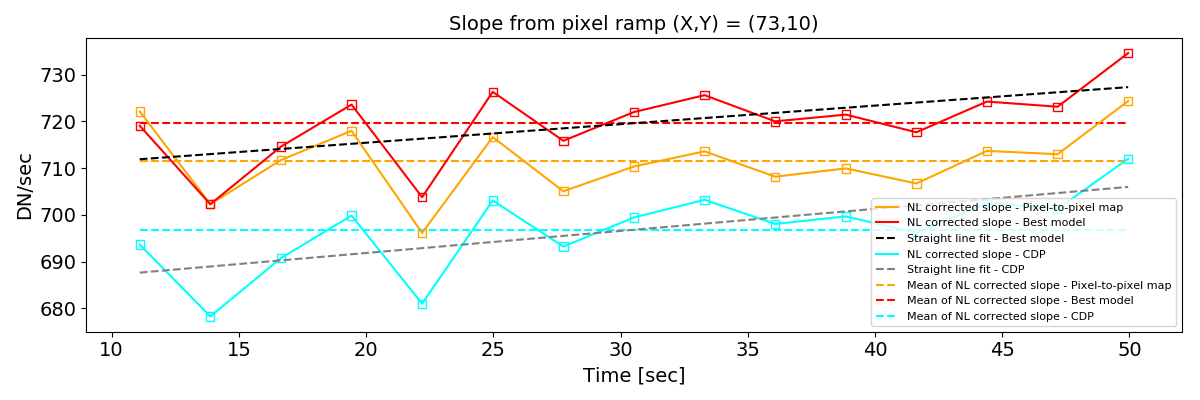

In [18]:
#solve for the correction factor as a function of observed DN.
coefs_PixelToPixelMapCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time, 1)
poly_PixelToPixelMapCorrection = np.poly1d(coefs_PixelToPixelMapCorrection[::-1])

print 'Linear fit coefficients - Pixel To Pixel Correction: {}'.format(coefs_PixelToPixelMapCorrection)

coefs_BestModelCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_BestModel)/frame_delta_time, 1)
poly_BestModelCorrection = np.poly1d(coefs_BestModelCorrection[::-1])

print 'Linear fit coefficients - Best Model Correction: {}'.format(coefs_BestModelCorrection)

coefs_CDPCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_CDP)/frame_delta_time, 1)
poly_CDPCorrection = np.poly1d(coefs_CDPCorrection[::-1])

print 'Linear fit coefficients - CDP Correction: {}'.format(coefs_CDPCorrection)

plt.figure(figsize=(12,4))
plt.scatter(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,marker='s',facecolors='none',edgecolors='orange')
plt.plot(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,'orange',label='NL corrected slope - Pixel-to-pixel map')
plt.hlines(np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'orange',linestyle='dashed',label='Mean of NL corrected slope - Pixel-to-pixel map')
plt.plot(intime[:-1],poly_BestModelCorrection(intime[:-1]),'k',linestyle='dashed',label='Straight line fit - Best model')

plt.scatter(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,marker='s',facecolors='none',edgecolors='r')
plt.plot(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,'r',label='NL corrected slope - Best model')
plt.hlines(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'r',linestyle='dashed',label='Mean of NL corrected slope - Best model')
plt.plot(intime[:-1],poly_BestModelCorrection(intime[:-1]),'k',linestyle='dashed',label='Straight line fit - Best model')

plt.scatter(intime[:-1],np.diff(corrected_ramp_CDP)/frame_delta_time,marker='s',facecolors='none',edgecolors='cyan')
plt.plot(intime[:-1],np.diff(corrected_ramp_CDP)/frame_delta_time,'cyan',label='NL corrected slope - CDP')
plt.hlines(np.mean(np.diff(corrected_ramp_CDP)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'cyan',linestyle='dashed',label='Mean of NL corrected slope - CDP')
plt.plot(intime[:-1],poly_CDPCorrection(intime[:-1]),'gray',linestyle='dashed',label='Straight line fit - CDP')

plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN/sec',fontsize=14)
plt.title('Slope from pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.legend(fontsize=8)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

## Derive non-linearity corrected relevant parameters for a single trace in MRS slice

In [17]:
# initialize placeholders
gradient = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_at_time0 = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_BestModel = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_pixelTopixelCorr = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
for i in range(1024):
    if i%100 == 0:
        print 'Row {}'.format(i)
    ypos,xpos = trace_y[i],trace_x[i]
    time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
    tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
    time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
    time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

    # derive non-linearity correction
    intime = time3
    inramp = tramp3
    
    #solve for the correction factor as a function of observed DN.
    cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
    cor_factor_BestModel = np.polynomial.polynomial.polyval(inramp, nl_coefficients_BestModel[:, ypos, xpos])
    
    # correct ramp by applying derived NL correction
    corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
    corrected_ramp_BestModel = cor_factor_BestModel * inramp
    
    # 
    coefs_BestModelCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_BestModel)/frame_delta_time, 1)
    
    # insert results in placeholder array
    gradient[ypos,xpos] = coefs_BestModelCorrection[1]
    slope_at_time0[ypos,xpos] = coefs_BestModelCorrection[0]
    slope_BestModel[ypos,xpos] = np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time)
    slope_pixelTopixelCorr[ypos,xpos] = np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time)

Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


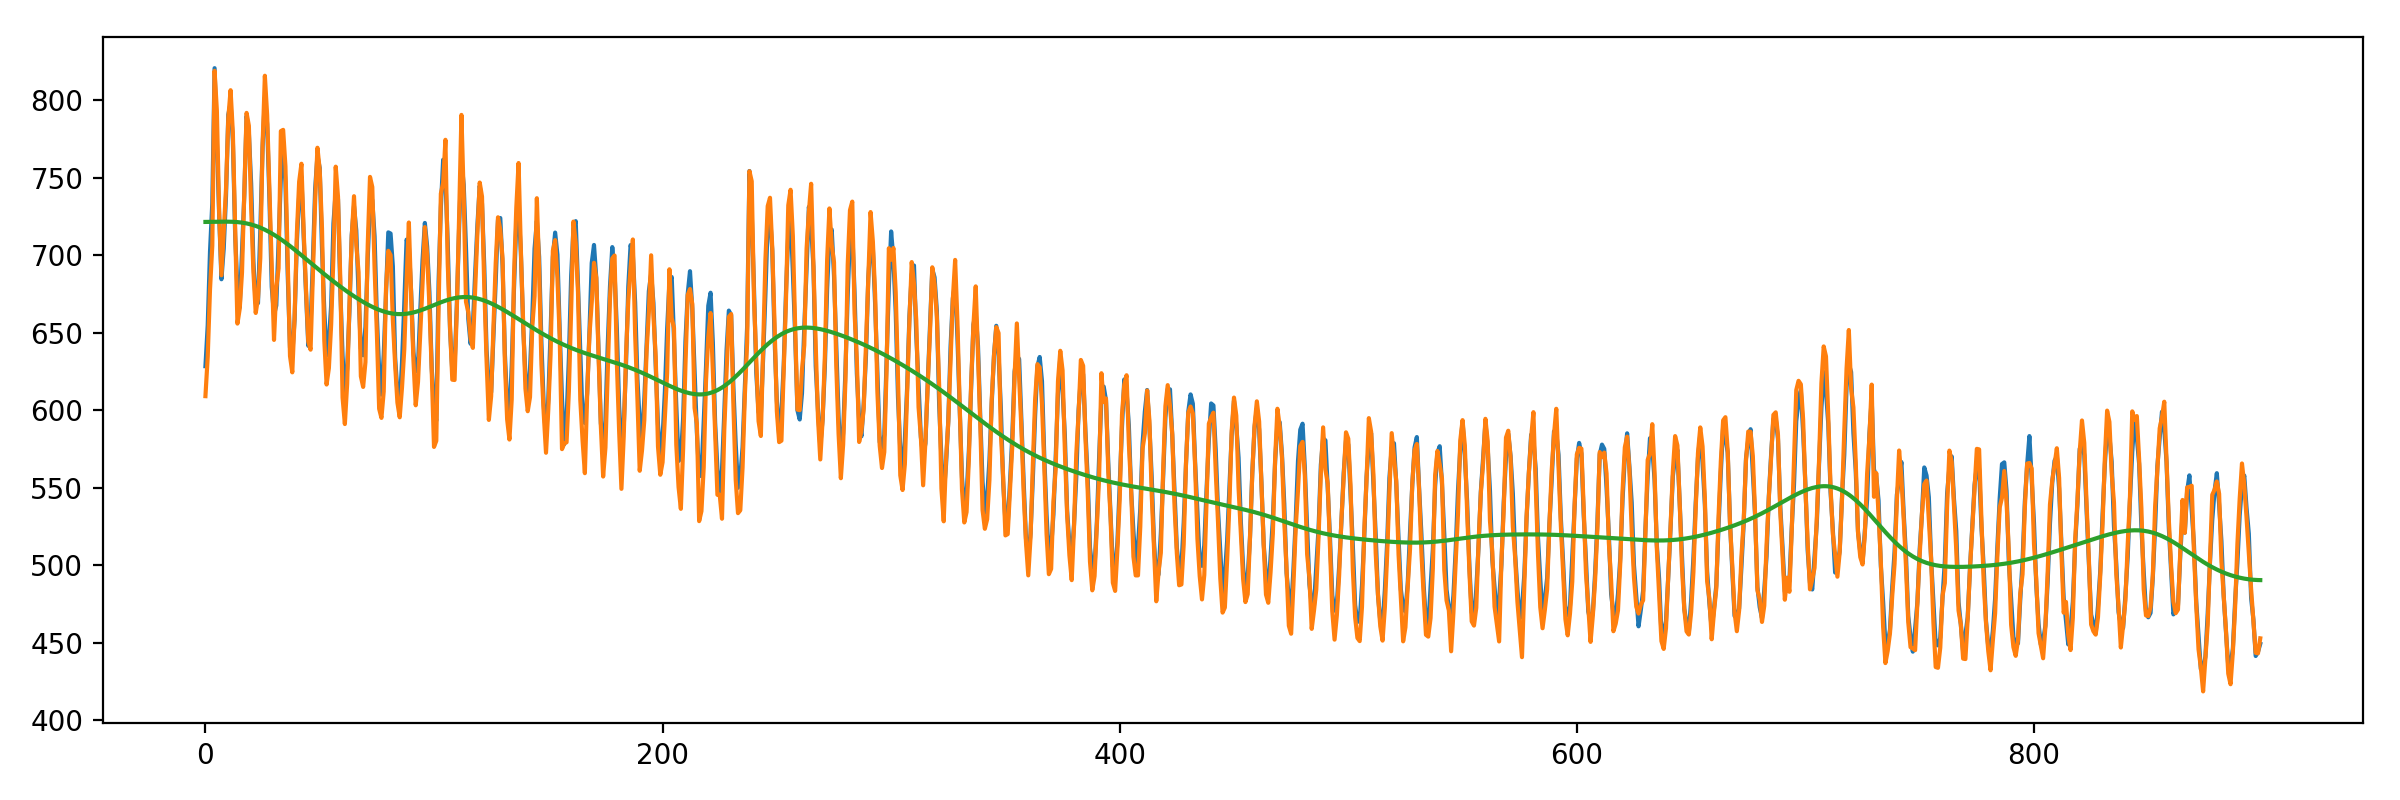

In [19]:
plt.close('all')

d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
trace_y,trace_x = trace_y[50:950],trace_x[50:950]

sigma_smooth = 15
plt.figure(figsize=(12,4))
plt.plot(slope_BestModel[trace_y,trace_x])
plt.plot(slope_pixelTopixelCorr[trace_y,trace_x])
plt.plot(gaussian_filter1d(slope_pixelTopixelCorr[trace_y,trace_x],sigma_smooth))
plt.tight_layout()


## Derive non-linearity corrected relevant parameters for full MRS detector

In [27]:
# initialize placeholders
gradient_BestModel = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
gradient_pixelTopixelCorr = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
gradient_CDP = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_at_time0 = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_BestModel = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_pixelTopixelCorr = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_CDP = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_uncorrected = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

for ypos,xpos in itertools.product(range(1024),range(512)):
    if (xpos==511) & (ypos%100 == 0):
        print 'Row {}'.format(ypos)
    if d2cMaps['sliceMap'][ypos,xpos] != 0:
        try:
            time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
            if analyze_ramp != 1:
                time = time-time[0]+frame_delta_time
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

            # derive non-linearity correction
            intime = time3
            inramp = tramp3

            #solve for the correction factor as a function of observed DN.
            cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
            cor_factor_BestModel = np.polynomial.polynomial.polyval(inramp, nl_coefficients_BestModel[:, ypos, xpos])

            # correct ramp by applying derived NL correction
            corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
            corrected_ramp_BestModel = cor_factor_BestModel * inramp
            corrected_ramp_CDP = np.zeros(len(inramp))
            for i in range(len(inramp)):
                corrected_ramp_CDP[i] = corrected_ramp_CDP[i]+nl_coefficients_CDP[0,ypos, xpos]+\
                                        nl_coefficients_CDP[1,ypos, xpos]*inramp[i]+\
                                        nl_coefficients_CDP[2,ypos, xpos]*inramp[i]**2+\
                                        nl_coefficients_CDP[3,ypos, xpos]*inramp[i]**3+\
                                        nl_coefficients_CDP[4,ypos, xpos]*inramp[i]**4

            # 
            coefs_BestModelCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_BestModel)/frame_delta_time, 1)
            coefs_pixelTopixelCorr = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time, 1)
            coefs_CDPCorr = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_CDP)/frame_delta_time, 1)

            # insert results in placeholder array
            gradient_BestModel[ypos,xpos] = coefs_BestModelCorrection[1]
            gradient_pixelTopixelCorr[ypos,xpos] = coefs_pixelTopixelCorr[1]
            gradient_CDP[ypos,xpos] = coefs_CDPCorr[1]
            slope_at_time0[ypos,xpos] = coefs_BestModelCorrection[0]
            slope_BestModel[ypos,xpos] = np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time)
            slope_pixelTopixelCorr[ypos,xpos] = np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time)
            slope_CDP[ypos,xpos] = np.mean(np.diff(corrected_ramp_CDP)/frame_delta_time)
            slope_uncorrected[ypos,xpos] = np.mean(np.diff(inramp)/frame_delta_time)
        except:
            pass

Row 0
Row 100
Row 200
Row 300
Row 400


/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:39: RankWarning: The fit may be poorly conditioned
/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:40: RankWarning: The fit may be poorly conditioned
/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:41: RankWarning: The fit may be poorly conditioned


Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


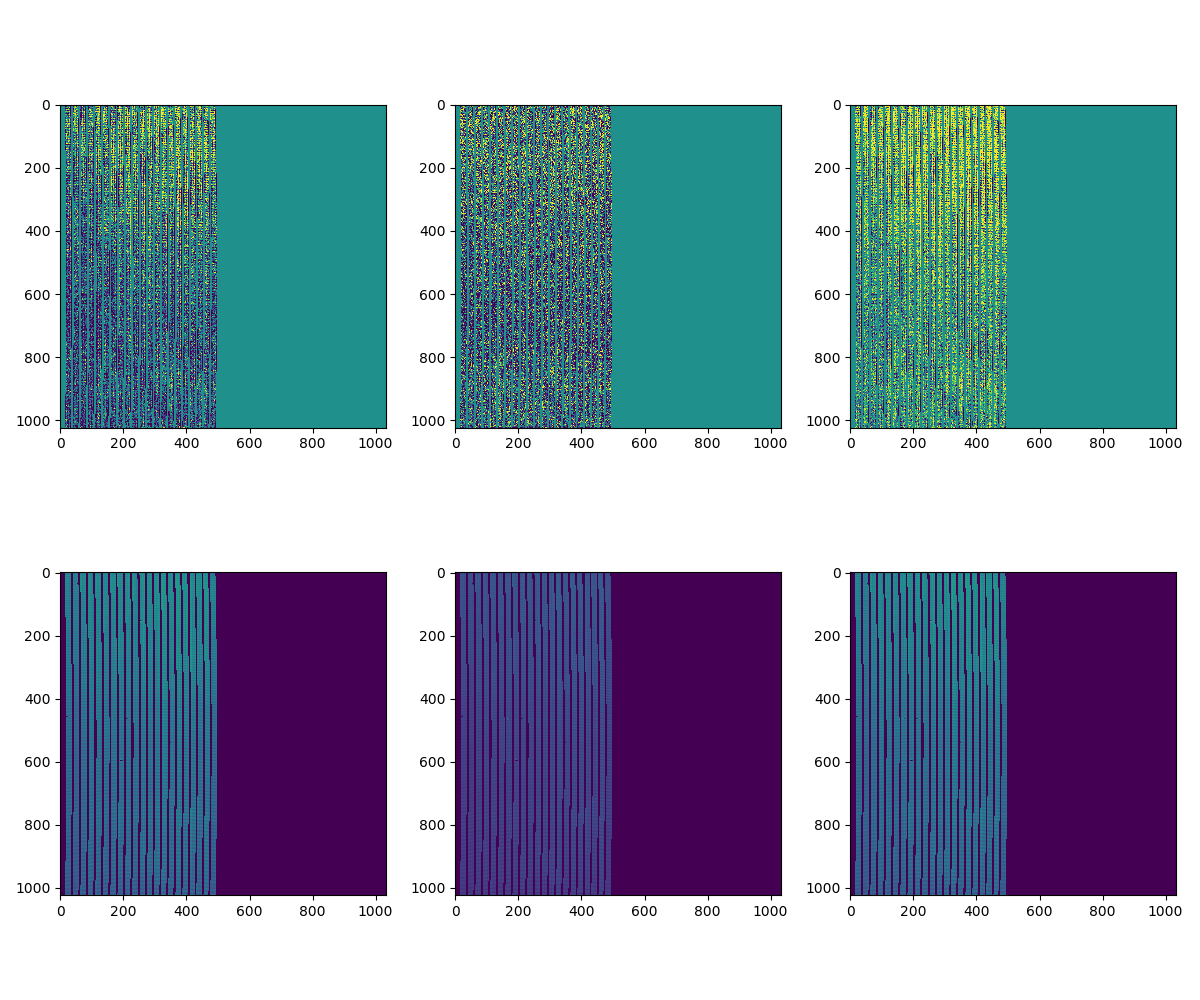

In [28]:
plt.close('all')
fig,axs = plt.subplots(2,3,figsize=(12,10))
axs[0,0].imshow(gradient_BestModel,vmin=-0.3,vmax=0.3)
axs[0,1].imshow(gradient_pixelTopixelCorr,vmin=-0.3,vmax=0.3)
axs[0,2].imshow(gradient_CDP,vmin=-0.3,vmax=0.3)
axs[1,0].imshow(slope_BestModel)
axs[1,1].imshow(slope_pixelTopixelCorr)
axs[1,2].imshow(slope_CDP)
plt.tight_layout()

### Compute histograms of residual gradient for BestModel and PixelToPixel correction

(-0.12180134239815382, 0.264042346244465)
(-0.1270888307116554, 0.30069934266365345)
(0.055435761545674214, 0.26483665797169004)


<IPython.core.display.Javascript object>


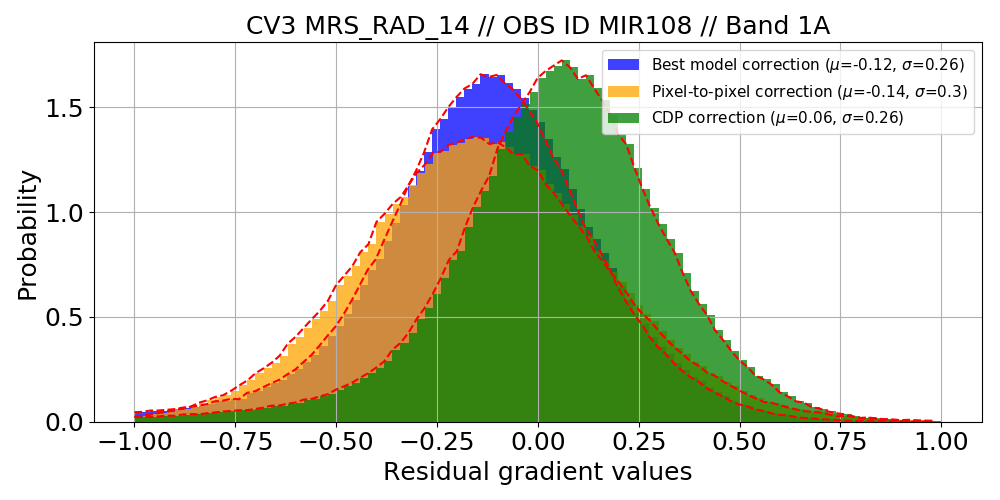

In [29]:
(mu_BestModel, sigma_BestModel) = norm.fit(gradient_BestModel[sel][(gradient_BestModel[sel]>-1) & (gradient_BestModel[sel]<1)])
print (mu_BestModel, sigma_BestModel)

(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(gradient_pixelTopixelCorr[sel][(gradient_pixelTopixelCorr[sel]>-1) & (gradient_pixelTopixelCorr[sel]<1)])
print (mu_pixelTopixelCorr, sigma_pixelTopixelCorr)

(mu_CDP, sigma_CDP) = norm.fit(gradient_CDP[sel][(gradient_CDP[sel]>-1) & (gradient_CDP[sel]<1)])
print (mu_CDP, sigma_CDP)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(gradient_BestModel[sel][(gradient_BestModel[sel]>-1) & (gradient_BestModel[sel]<1)], 100, normed=1, facecolor='b', alpha=0.75,label='Best model correction ($\mu$={}, $\sigma$={})'.format(round(mu_BestModel,2),round(sigma_BestModel,2)))
y = mlab.normpdf(bins, mu_BestModel, sigma_BestModel)
# plt.plot(bins, y, 'r--', linewidth=2)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(gradient_pixelTopixelCorr[sel][(gradient_pixelTopixelCorr[sel]>-1) & (gradient_pixelTopixelCorr[sel]<1)], 100, normed=1, facecolor='orange', alpha=0.75,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(bins[n.argmax()],2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(gradient_CDP[sel][(gradient_CDP[sel]>-1) & (gradient_CDP[sel]<1)], 100, normed=1, facecolor='g', alpha=0.75,label=r'CDP correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP,2),round(sigma_CDP,2)) )
y = mlab.normpdf(bins, mu_CDP, sigma_CDP)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
plt.xlabel('Residual gradient values',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.legend(fontsize=11)
plt.grid(True)
plt.title('CV3 MRS_RAD_14 // OBS ID MIR108 // Band {}'.format(band),fontsize=18)
plt.tight_layout()

(-0.0017302885706728193, 0.0013151847777327515)
(-0.0017371765654024332, 0.0014226095383465967)
(0.00015754408315961607, 0.0012560195169865793)


<IPython.core.display.Javascript object>


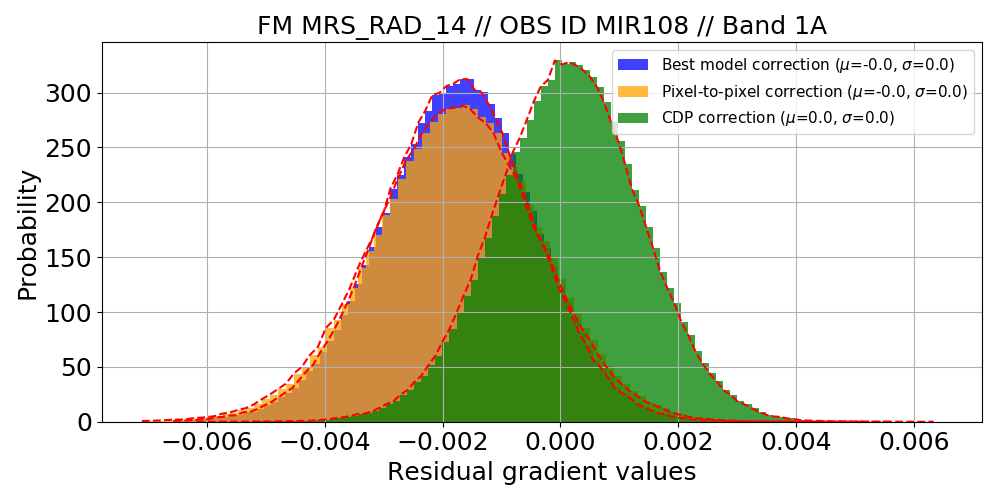

In [24]:
(mu_BestModel, sigma_BestModel) = norm.fit(gradient_BestModel[sel][(gradient_BestModel[sel]>-0.025) & (gradient_BestModel[sel]<0.025)])
print (mu_BestModel, sigma_BestModel)

(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(gradient_pixelTopixelCorr[sel][(gradient_pixelTopixelCorr[sel]>-0.025) & (gradient_pixelTopixelCorr[sel]<0.025)])
print (mu_pixelTopixelCorr, sigma_pixelTopixelCorr)

(mu_CDP, sigma_CDP) = norm.fit(gradient_CDP[sel][(gradient_CDP[sel]>-0.025) & (gradient_CDP[sel]<0.025)])
print (mu_CDP, sigma_CDP)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(gradient_BestModel[sel][(gradient_BestModel[sel]>-5*sigma_BestModel) & (gradient_BestModel[sel]<5*sigma_BestModel)], 100, normed=1, facecolor='b', alpha=0.75,label='Best model correction ($\mu$={}, $\sigma$={})'.format(round(mu_BestModel,2),round(sigma_BestModel,2)))
y = mlab.normpdf(bins, mu_BestModel, sigma_BestModel)
# plt.plot(bins, y, 'r--', linewidth=2)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(gradient_pixelTopixelCorr[sel][(gradient_pixelTopixelCorr[sel]>-5*sigma_pixelTopixelCorr) & (gradient_pixelTopixelCorr[sel]<5*sigma_pixelTopixelCorr)], 100, normed=1, facecolor='orange', alpha=0.75,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(bins[n.argmax()],2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(gradient_CDP[sel][(gradient_CDP[sel]>-5*sigma_CDP) & (gradient_CDP[sel]<5*sigma_CDP)], 100, normed=1, facecolor='g', alpha=0.75,label=r'CDP correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP,2),round(sigma_CDP,2)) )
y = mlab.normpdf(bins, mu_CDP, sigma_CDP)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
plt.xlabel('Residual gradient values',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.legend(fontsize=11)
plt.grid(True)
plt.title('FM MRS_RAD_14 // OBS ID MIR108 // Band {}'.format(band),fontsize=18)
plt.tight_layout()

### Remarks:
* The residual gradient values seem to be asymmetric. This negatively impacts the Gaussian distribution fit.
  
The residual gradient seems to be correlated to the fringes. What are the values are fringe peaks and fringe troughs?

<IPython.core.display.Javascript object>


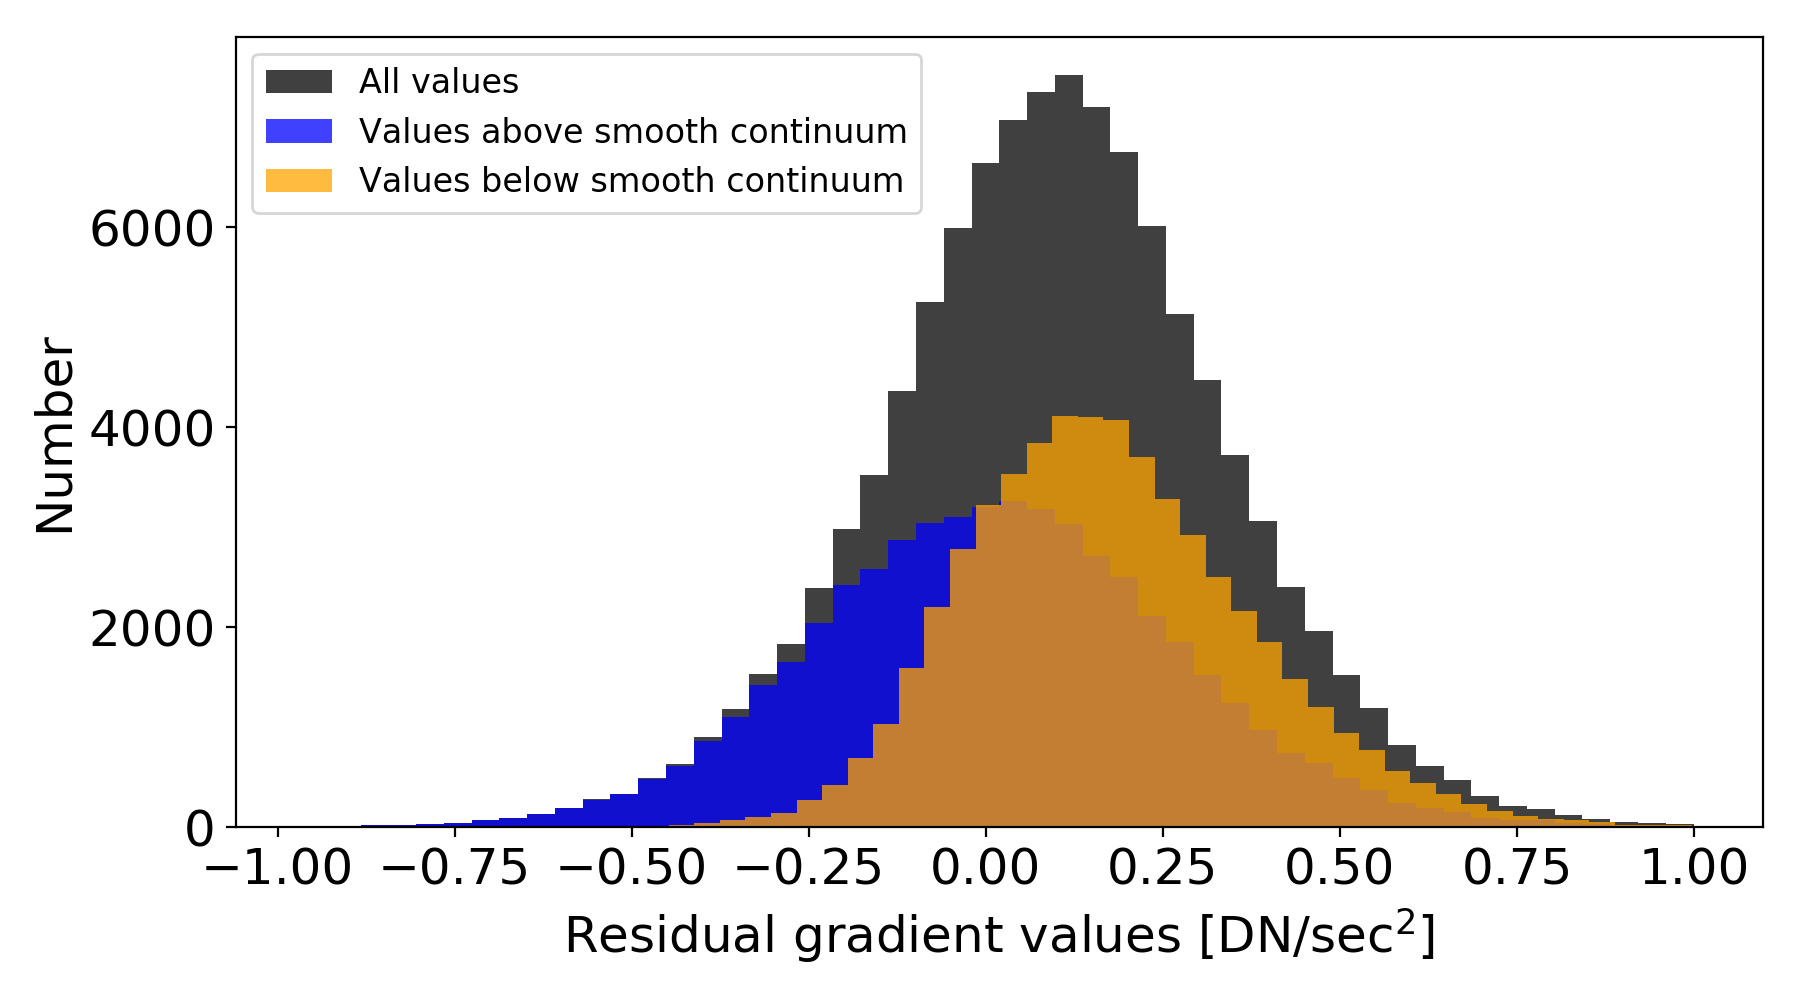

In [23]:
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

sigma_smooth = 15
values = []
values_above,values_below = [],[]
for islice in range(1,d2cMaps['nslices']+1):
    trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=0.)
#     trace_y,trace_x = trace_y[50:200],trace_x[50:200]
    for offset in range(-2,3):
        sel_above = (slope_uncorrected[trace_y,trace_x+offset]-gaussian_filter1d(slope_uncorrected[trace_y,trace_x+offset],sigma_smooth)) > 0
        sel_below = (slope_uncorrected[trace_y,trace_x+offset]-gaussian_filter1d(slope_uncorrected[trace_y,trace_x+offset],sigma_smooth)) < 0
        values.extend(gradient[trace_y,trace_x+offset])
        values_above.extend(gradient[trace_y,trace_x+offset][sel_above])
        values_below.extend(gradient[trace_y,trace_x+offset][sel_below])
values = np.array(values)
values_above = np.array(values_above)
values_below = np.array(values_below)

plt.figure(figsize=(9,5))
plt.hist(values[(values>-1) & (values<1)], 50, facecolor='k', alpha=0.75,label='All values')
plt.hist(values_above[(values_above>-1) & (values_above<1)], 50, facecolor='b', alpha=0.75,label='Values above smooth continuum')
plt.hist(values_below[(values_below>-1) & (values_below<1)], 50, facecolor='orange', alpha=0.75,label='Values below smooth continuum')
plt.xlabel(r'Residual gradient values [DN/sec$^2$]',fontsize=18)
plt.ylabel('Number',fontsize=18)
plt.legend(fontsize=12)
plt.tick_params(axis='both',labelsize=18)
plt.tight_layout()

<IPython.core.display.Javascript object>


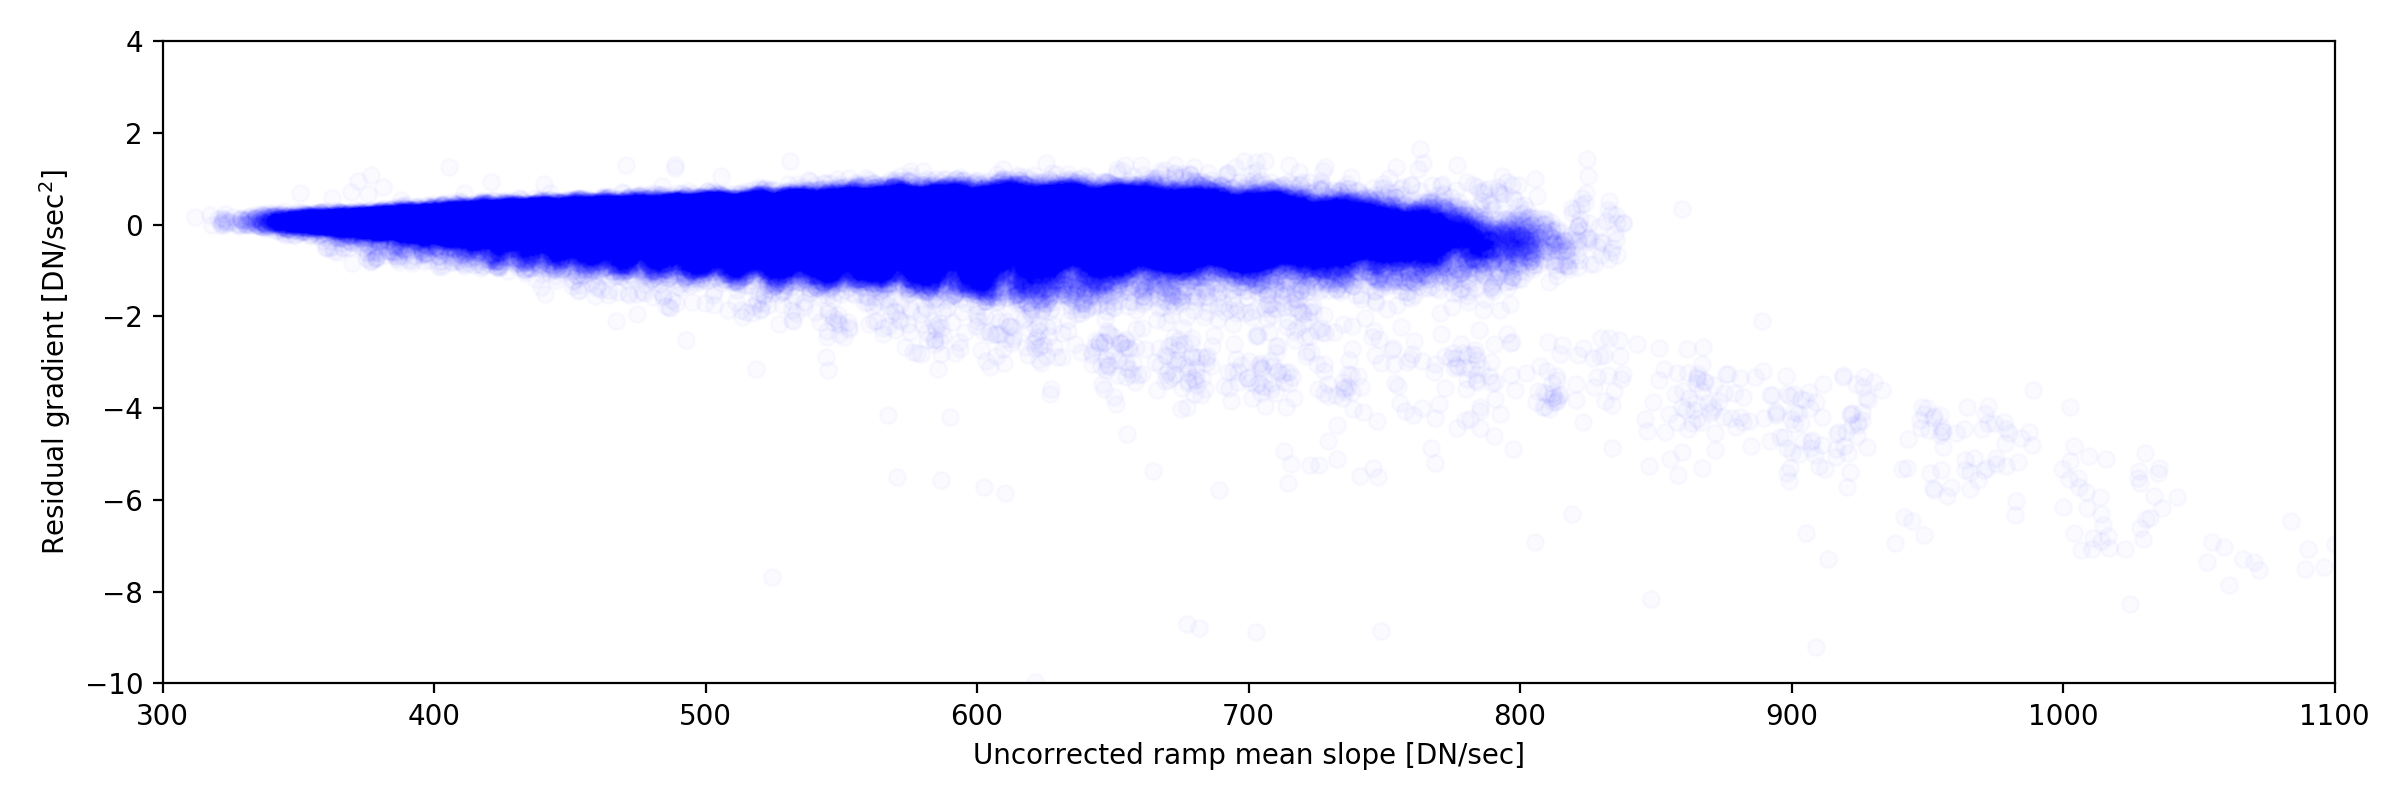

In [25]:
plt.close('all')
plt.figure(figsize=(12,4))
plt.plot(slope_uncorrected[sel],gradient[sel],'bo',alpha=0.02)
plt.ylim(-10,4)
plt.xlim(300,1100)
plt.xlabel('Uncorrected ramp mean slope [DN/sec]')
plt.ylabel(r'Residual gradient [DN/sec$^2$]')
plt.tight_layout()

<IPython.core.display.Javascript object>


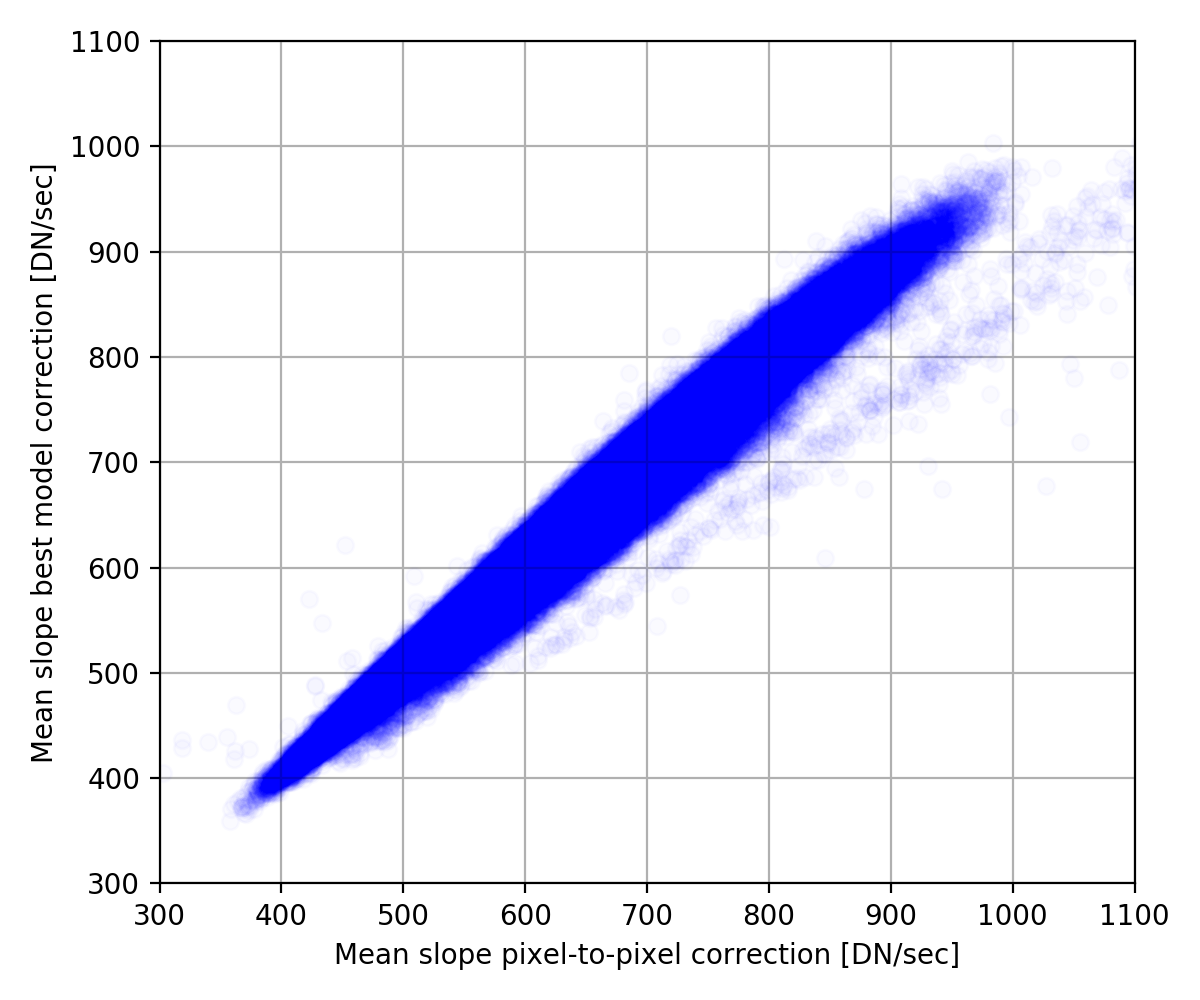

In [26]:
plt.close('all')

plt.figure(figsize=(6,5))
plt.plot(slope_pixelTopixelCorr[sel],slope_BestModel[sel],'bo',alpha=0.02)
plt.xlim(300,1100)
plt.ylim(300,1100)
plt.xlabel('Mean slope pixel-to-pixel correction [DN/sec]')
plt.ylabel('Mean slope best model correction [DN/sec]')
plt.grid()
plt.tight_layout()

### Remarks:
* Plotting the pixel-to-pixel mean slope values versus the best model mean slope values, there is a large scatter for every "ideally corrected" (i.e. pixel-to-pixel corrected) slope value. An ideally corrected flux value of e.g. 700DN/sec yields a range in the best model results of 630DN/sec - to - 750DN/sec. This is a huge scatter!
* There seems to be a second group of values 